In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
import cv2
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc 
from functools import reduce
import wfdb#https://github.com/MIT-LCP/wfdb-python
from wfdb import processing
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
torch.cuda.set_device(1)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


1


In [2]:
#read train image with CV
train_dir = '/data/fjsdata/ECG/MIT-BIH/train' #the path of images
trN, trI, trY = [],[],[]
for iname in os.listdir(train_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(train_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            trN.append(iname)
            trI.append(img)
            trY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(trY),20000))
        sys.stdout.flush()
print('The length of train set is %d'%len(trY))
#read test image with CV
test_dir = '/data/fjsdata/ECG/MIT-BIH/test' #the path of images
teN, teI, teY = [],[],[]
for iname in os.listdir(test_dir):
    if iname.endswith(".png"):
        try:
            image_path = os.path.join(test_dir, iname)
            itype = int(os.path.splitext(iname)[0].split("-")[1])
            img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(500,300,3)->(256,256,3)
            teN.append(iname)
            teI.append(img)
            teY.append(itype)
        except:
            print(iname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(teY),20000))
        sys.stdout.flush()
print('The length of test set is %d'%len(teY))

20000 / 20000 The length of train set is 20000
20000 / 20000 The length of test set is 20000


In [7]:
#ATH model with Tripet loss
class SpatialAttention(nn.Module):#spatial attention layer
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True) #resnet

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ATHNet(nn.Module):
    def __init__(self, hash_size: int, type_size: int):
        super().__init__()
        #resnet and maxpool
        self.net1 = nn.Sequential(#(3,256,256)->(16,128,128)
            ResBlock(in_channels=3, out_channels=16, stride=2), 
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
        )
        
        #Attention (16,128,128)->(16,128,128)
        self.sa = SpatialAttention()
        
        #resnet and meanpool
        self.net2 =nn.Sequential( #(16,128,128)->(8,64,64)
            ResBlock(in_channels=16, out_channels=8, stride=2),
            nn.AvgPool2d(kernel_size=3, padding=1, stride=1)
        ) 
         
        #fully connected with conv (8,64,64)->(1,32,32)
        self.dense=ResBlock(in_channels=8, out_channels=1, stride=2)
        #fully connected (1,32,32)->class_size
        self.hashlayer = nn.Linear(1*32*32, hash_size)
        self.typelayer = nn.Linear(1*32*32, type_size)
    
        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net1(x)
        x = self.sa(x)*x
        x = self.net2(x)
        x = self.dense(x)
        x = x.view(x.size(0),-1)
        x_hash = self.hashlayer(x)
        x_type = self.typelayer(x)
        return x_hash, x_type

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

#https://github.com/luyajie/triplet-deep-hash-pytorch#triplet-deep-hash-pytorch            
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self,H_q,H_p,H_n):    
        margin_val = self.margin * H_q.shape[1]
        squared_loss_pos = torch.mean(self.mse_loss(H_q, H_p), dim=1)
        squared_loss_neg = torch.mean(self.mse_loss(H_q, H_n), dim=1)
        zeros = torch.zeros_like(squared_loss_neg)
        loss  = torch.max(zeros, margin_val - squared_loss_neg + squared_loss_pos)
        return torch.mean(loss)

class FocalLoss(nn.Module):
    #Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, out, y):
        y = y.view(-1,1)
        logpt = F.log_softmax(out,dim=1)#default ,dim=1
        logpt = logpt.gather(1,y)# dim=1, index=y, max
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=out.data.type():
                self.alpha = self.alpha.type_as(out.data)
            at = self.alpha.gather(0,y.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

class CircleLoss(nn.Module):
    def __init__(self, scale=32, margin=0.25, similarity='cos', **kwargs):
        super(CircleLoss, self).__init__()
        self.scale = scale
        self.margin = margin
        self.similarity = similarity

    def forward(self, feats, labels):
        assert feats.size(0) == labels.size(0), \
            f"feats.size(0): {feats.size(0)} is not equal to labels.size(0): {labels.size(0)}"
        batch_size = feats.size(0)
        if self.similarity == 'dot':
            sim_mat = torch.matmul(feats, torch.t(feats))
        elif self.similarity == 'cos':
            feats = F.normalize(feats)
            sim_mat = feats.mm(feats.t())
        else:
            raise ValueError('This similarity is not implemented.')
        loss = list()
        for i in range(batch_size):
            pos_index = labels == labels[i]
            pos_index[i] = 0
            neg_index = labels != labels[i]
            pos_pair_ = sim_mat[i][pos_index]
            neg_pair_ = sim_mat[i][neg_index]

            alpha_p = torch.relu(-pos_pair_ + 1 + self.margin)
            alpha_n = torch.relu(neg_pair_ + self.margin)
            margin_p = 1 - self.margin
            margin_n = self.margin
            loss_p = torch.sum(torch.exp(-self.scale * alpha_p * (pos_pair_ - margin_p)))
            loss_n = torch.sum(torch.exp(self.scale * alpha_n * (neg_pair_ - margin_n)))
            loss.append(torch.log(1 + loss_p * loss_n))

        loss = sum(loss) / batch_size
        return loss
    
#Generate image pairs for model
def onlineGenImgPairs( ):
    idx_sf = []
    idx_0 = np.where( np.array(trY) == 0 ) #class 0
    idx_0 = list(idx_0[0])[0:4555]
    idx_sf.extend(idx_0)
    idx_1 = np.where( np.array(trY) == 1 ) #class 1
    idx_1 = list(idx_1[0])
    idx_sf.extend(idx_1)
    idx_2 = np.where( np.array(trY) == 2 ) #class 2
    idx_2 = list(idx_2[0])
    idx_sf.extend(idx_2)
    idx_3 = np.where( np.array(trY) == 3 ) #class 3
    idx_3 = list(idx_3[0])
    idx_sf.extend(idx_3)
    random.shuffle(idx_sf)   
    trQ_sf, trP_sf, trN_sf = [], [], []
    trQ_y, trP_y, trN_y = [], [], []
    for iQ in idx_sf:
        trQ_sf.append(trI[iQ])
        trQ_y.append(trY[iQ])
        if trY[iQ] == 0:
            idx_tmp = idx_0.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_0))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 1:
            idx_tmp = idx_1.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_1))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 2:
            idx_tmp = idx_2.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_2))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        elif trY[iQ] == 3:
            idx_tmp = idx_3.copy()
            idx_tmp.remove(iQ)
            iP =  random.sample(idx_tmp,1) #remove self,then get one positive sample
            trP_sf.append(trI[iP[0]])
            trP_y.append(trY[iP[0]])
            idx_sf_tmp = list(set(idx_sf) - set(idx_3))
            iN =  random.sample(idx_sf_tmp,1) #remove positive and get one negative sample
            trN_sf.append(trI[iN[0]])
            trN_y.append(trY[iN[0]])
        else: pass
        sys.stdout.write('\r{} / {} '.format(len(trQ_sf),len(idx_sf)))
        sys.stdout.flush()
    return np.array(trQ_sf),np.array(trP_sf),np.array(trN_sf), np.array(trQ_y), np.array(trP_y), np.array(trN_y)

In [12]:
#--------------------------------------------------------
#ATH-Triplet+CE
#--------------------------------------------------------
#sample  triplet labels
#trQ_sf, trP_sf, trN_sf, trQ_y, trP_y, trN_y = onlineGenImgPairs() 
assert (trQ_sf.shape==trP_sf.shape and trQ_sf.shape==trN_sf.shape)
assert (trQ_y.shape==trP_y.shape and trQ_y.shape==trN_y.shape)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trP_y))!=0,1,0))==0.0)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trN_y))!=0,1,0))==1.0)

#define model
model = ATHNet(hash_size=36, type_size=4).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
tl_loss  = TripletLoss(margin=0.5).cuda() #define TripletLoss 
ce_loss  = nn.CrossEntropyLoss().cuda() #define ce mutli-classes

#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_q_y = trQ_y[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_p_y = trP_y[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    train_n_y = trN_y[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Q_y_batch = torch.from_numpy(train_q_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_y_batch = torch.from_numpy(train_p_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_y_batch = torch.from_numpy(train_n_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        Q_hash, Q_type = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash, P_type = model(P_batch.permute(0, 3, 1, 2))
        N_hash, N_type = model(N_batch.permute(0, 3, 1, 2))
        #loss
        hash_loss = tl_loss(Q_hash,P_hash,N_hash)
        type_loss = ce_loss(Q_type,Q_y_batch) + ce_loss(P_type,P_y_batch) + ce_loss(N_type,N_y_batch) #F.log_softmax+F.nll_loss
        loss = hash_loss+type_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
tl_loss=tl_loss.cpu()
ce_loss=ce_loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch,_ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_type = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_type = F.log_softmax(x_type,dim=1) 
    pred = x_type.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#performance of retrieval
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance of classification
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 1000 / 1000 : loss = 5.687949Eopch:     1 mean_loss = 4.556495
 1000 / 1000 : loss = 0.655146Eopch:     2 mean_loss = 2.481055
 1000 / 1000 : loss = 4.568817Eopch:     3 mean_loss = 1.956790
 1000 / 1000 : loss = 3.142055Eopch:     4 mean_loss = 1.671847
 1000 / 1000 : loss = 2.031145Eopch:     5 mean_loss = 1.358368
 1000 / 1000 : loss = 1.992266Eopch:     6 mean_loss = 1.097068
 1000 / 1000 : loss = 0.132002Eopch:     7 mean_loss = 0.876472
 1000 / 1000 : loss = 0.098145Eopch:     8 mean_loss = 0.710833
 1000 / 1000 : loss = 0.548056Eopch:     9 mean_loss = 0.538750
 1000 / 1000 : loss = 0.022405Eopch:    10 mean_loss = 0.478881
best_loss = 0.478881
 1999 / 2000 Completed buliding index in 1 seconds
mHR@10=0.774720, mAP@10=0.746217, mRR@10=0.937980
Accuracy: 0.717500
[[10428   963  3232   231]
 [  212   440   268    24]
 [  280   101  3355    52]
 [  206     2    79   127]]
Specificity of N: 0.702033
Sensitivity of S: 0.466102
Sensitivity of V: 0.885692
Sensitivity of F: 0.306763


Org data dimension is 36.Embedded data dimension is 2


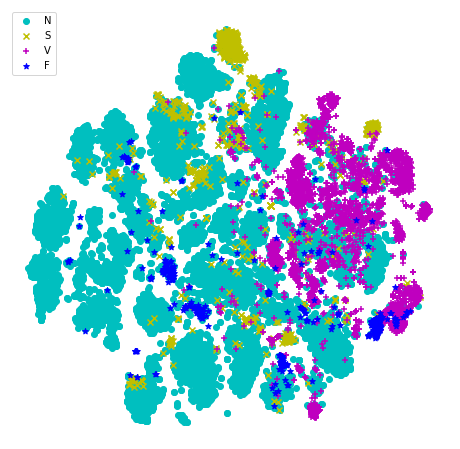

In [13]:
#visualize : t-SNE
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import random
def scatter(X, y):
    #X,y:numpy-array
    classes = len(list(set(y.tolist())))#get number of classes
    #palette = np.array(sns.color_palette("hls", classes))# choose a color palette with seaborn.
    color = ['c','y','m','b','g','r']
    marker = ['o','x','+','*','s']
    label = ['N','S','V','F']
    plt.figure(figsize=(8,8))#create a plot
    for i in range(classes):
        plt.scatter(X[y == i,0], X[y == i,1], c=color[i], marker=marker[i], label=label[i])
    plt.axis('off')
    plt.legend(loc='upper left')
    #plt.savefig('digits_tsne-generated.png', dpi=100)
    plt.show()

#prepare data，classes=5
#idx= random.sample(np.where(np.array(teY)==0)[0].tolist(),100)
idx= np.where(np.array(teY)==0)[0].tolist()
X0= np.array(teF)[idx]
y0= np.array(teY)[idx]

idx= np.where(np.array(teY)==1)[0].tolist()
X1= np.array(teF)[idx]
y1= np.array(teY)[idx]

idx= np.where(np.array(teY)==2)[0].tolist()
X2= np.array(teF)[idx]
y2= np.array(teY)[idx]

idx= np.where(np.array(teY)==3)[0].tolist()
X3= np.array(teF)[idx]
y3= np.array(teY)[idx]

y = np.append(y0,y1)
y = np.append(y,y2)
y = np.append(y,y3)
X = np.vstack((X0,X1))
X = np.vstack((X,X2))
X = np.vstack((X,X3))
#training t-sne 
tsne = TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
print("Org data dimension is {}.Embedded data dimension is {}".format(X.shape[-1], X_tsne.shape[-1]))

#visualize
scatter(X_tsne, y)

In [15]:
# generate class activation mapping for the top1 prediction
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    
    output_cam = []
    for idx in class_idx:
        #cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc,h*w)))
        cam = weight_softmax[class_idx]*(feature_conv.reshape((nc,h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
#last conv layer followed with one channel by last fully connected layer
final_conv = 'dense' 
best_net._modules.get(final_conv).register_forward_hook(hook_feature)
#get weights parameters
params = list(best_net.parameters())
#get the last and second last weights, like [classes, hiden nodes]
weight_softmax = np.squeeze(params[-2].data.cpu().numpy()) 
# define class type
classes = {0: 'N', 1: 'S', 2:'V', 3:'F'}
#read image
root='/data/fjsdata/ECG/MIT-BIH/test/9939-2.png'
img = []
img.append( cv2.resize(cv2.imread(root).astype(np.float32), (256, 256)))#(256, 256) is the model input size
data = torch.from_numpy(np.array(img)).type(torch.FloatTensor).cuda()
_,logit = best_net(data.permute(0, 3, 1, 2))#forword
h_x = F.softmax(logit, dim=1).data.squeeze()#softmax
probs, idx = h_x.sort(0, True) #probabilities of classes

# output: the prediction
for i in range(0, len(classes)):
    line = '{:.3f} -> {}'.format(probs[i], classes[idx[i].item()])
    print(line)
#get the class activation maps
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0].item()])

# render the CAM and show
print('output CAM.jpg for the top1 prediction: %s' % classes[idx[0].item()])
img = cv2.imread(root)
height, width, _ = img.shape
CAM = cv2.resize(CAMs[0], (width, height))
heatmap = cv2.applyColorMap(CAM, cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('MIT-BIH_cam.jpg', result)

1.000 -> V
0.000 -> N
0.000 -> F
0.000 -> S
output CAM.jpg for the top1 prediction: V


True

In [32]:
#--------------------------------------------------------
#ATH-Triplet+Focal
#--------------------------------------------------------
#sample  triplet labels
#trQ_sf, trP_sf, trN_sf, trQ_y, trP_y, trN_y = onlineGenImgPairs() 
assert (trQ_sf.shape==trP_sf.shape and trQ_sf.shape==trN_sf.shape)
assert (trQ_y.shape==trP_y.shape and trQ_y.shape==trN_y.shape)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trP_y))!=0,1,0))==0.0)
assert (np.mean(np.where((np.array(trQ_y)-np.array(trN_y))!=0,1,0))==1.0)

#define model
model = ATHNet(hash_size=36, type_size=4).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
tl_loss  = TripletLoss(margin=0.5).cuda() #define TripletLoss 
fl_loss  = FocalLoss(gamma=2, alpha=[0.6,0.15,0.2,0.05]).cuda() #define focal loss

#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trQ_sf)))
    train_q = trQ_sf[shuffled_idx]
    train_q_y = trQ_y[shuffled_idx]
    train_p = trP_sf[shuffled_idx]
    train_p_y = trP_y[shuffled_idx]
    train_n = trN_sf[shuffled_idx]
    train_n_y = trN_y[shuffled_idx]
    num_batches = len(trQ_sf) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trQ_sf), (i+1)*batchSize])
        Q_batch = torch.from_numpy(train_q[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Q_y_batch = torch.from_numpy(train_q_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        P_batch = torch.from_numpy(train_p[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        P_y_batch = torch.from_numpy(train_p_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        N_batch = torch.from_numpy(train_n[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        N_y_batch = torch.from_numpy(train_n_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        Q_hash, Q_type = model(Q_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        P_hash, P_type = model(P_batch.permute(0, 3, 1, 2))
        N_hash, N_type = model(N_batch.permute(0, 3, 1, 2))
        #loss
        hash_loss = tl_loss(Q_hash,P_hash,N_hash)
        type_loss = fl_loss(Q_type,Q_y_batch) + fl_loss(P_type,P_y_batch) + fl_loss(N_type,N_y_batch)
        loss = hash_loss+type_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
tl_loss=tl_loss.cpu()
fl_loss=fl_loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch,_ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_type = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_type = F.log_softmax(x_type,dim=1) 
    pred = x_type.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#performance of retrieval
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance of classification
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 2000 / 2000 : loss = 1.4628117Eopch:     1 mean_loss = 2.901327
 2000 / 2000 : loss = 2.4868346Eopch:     2 mean_loss = 1.633266
 2000 / 2000 : loss = 2.7723198Eopch:     3 mean_loss = 1.223338
 2000 / 2000 : loss = 0.0126436Eopch:     4 mean_loss = 0.974957
 2000 / 2000 : loss = 0.0060015Eopch:     5 mean_loss = 0.811690
 2000 / 2000 : loss = 0.4236028Eopch:     6 mean_loss = 0.692112
 2000 / 2000 : loss = 0.0023165Eopch:     7 mean_loss = 0.657241
 2000 / 2000 : loss = 0.0002492Eopch:     8 mean_loss = 0.519214
 2000 / 2000 : loss = 0.0025774Eopch:     9 mean_loss = 0.469521
 2000 / 2000 : loss = 0.0268484Eopch:    10 mean_loss = 0.466192
best_loss = 0.466192
 1999 / 2000 Completed buliding index in 1 seconds
mHR@10=0.777395, mAP@10=0.751048, mRR@10=0.936099
Accuracy: 0.778150
[[11739   330  2701    84]
 [  352   322   263     7]
 [  288    38  3447    15]
 [  211     1   147    55]]
Specificity of N: 0.790292
Sensitivity of S: 0.341102
Sensitivity of V: 0.909979
Sensitivity of F: 0

In [28]:
#--------------------------------------------------------
#ATH-Circle+Focal
#--------------------------------------------------------
#define model
model = ATHNet(hash_size=36, type_size=4).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
cl_loss  = CircleLoss().cuda() #define CircleLoss 
fl_loss  = FocalLoss(gamma=2, alpha=[0.6,0.15,0.2,0.05]).cuda() #define focal loss

#train model
best_net, best_loss = None, float('inf')
batchSize = 10
trI = np.array(trI)
trY = np.array(trY)
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    train_x = trI[shuffled_idx]
    train_y = trY[shuffled_idx]
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        x_batch = torch.from_numpy(train_x[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(train_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forward
        out_hash, out_type = model(x_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        #loss
        hash_loss = cl_loss(out_hash,y_batch)
        type_loss = fl_loss(out_hash,y_batch) 
        loss = hash_loss+type_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
cl_loss=cl_loss.cpu()
fl_loss=fl_loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch,_ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_type = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_type = F.log_softmax(x_type,dim=1) 
    pred = x_type.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#performance of retrieval
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance of classification
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 2000 / 2000 : loss = 0.3438939Eopch:     1 mean_loss = 6.340153
 2000 / 2000 : loss = 20.088829Eopch:     2 mean_loss = 4.682155
 2000 / 2000 : loss = 0.5484276Eopch:     3 mean_loss = 4.133257
 2000 / 2000 : loss = 1.9490627Eopch:     4 mean_loss = 3.832483
 2000 / 2000 : loss = 0.0042885Eopch:     5 mean_loss = 3.715713
 2000 / 2000 : loss = 2.9334338Eopch:     6 mean_loss = 3.383951
 2000 / 2000 : loss = 0.0004236Eopch:     7 mean_loss = inf
 2000 / 2000 : loss = 0.3956893Eopch:     8 mean_loss = 3.118786
 2000 / 2000 : loss = 0.6861793Eopch:     9 mean_loss = 2.999954
 2000 / 2000 : loss = 1.8099163Eopch:    10 mean_loss = 2.947753
best_loss = 2.947753
 1999 / 2000 Completed buliding index in 1 seconds
mHR@10=0.781210, mAP@10=0.764656, mRR@10=0.948333
Accuracy: 0.369150
[[6433 6140 1286  995]
 [ 519  189   91  145]
 [2188  835  706   59]
 [ 157  189   13   55]]
Specificity of N: 0.433082
Sensitivity of S: 0.200212
Sensitivity of V: 0.186378
Sensitivity of F: 0.132850


In [30]:
#--------------------------------------------------------
#ATH-Circle+CE
#--------------------------------------------------------
#define model
model = ATHNet(hash_size=36, type_size=4).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
cl_loss  = CircleLoss().cuda() #define CircleLoss 
ce_loss  = nn.CrossEntropyLoss().cuda() #define ce mutli-classes

#train model
best_net, best_loss = None, float('inf')
batchSize = 10
trI = np.array(trI)
trY = np.array(trY)
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trY)))
    train_x = trI[shuffled_idx]
    train_y = trY[shuffled_idx]
    num_batches = len(trY) // batchSize
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY), (i+1)*batchSize])
        x_batch = torch.from_numpy(train_x[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(train_y[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forward
        out_hash, out_type = model(x_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        #loss
        hash_loss = cl_loss(out_hash,y_batch)
        type_loss = ce_loss(out_hash,y_batch) 
        loss = hash_loss+type_loss
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))

#release gpu memory
model = model.cpu()
cl_loss=cl_loss.cpu()
ce_loss=ce_loss.cpu()
torch.cuda.empty_cache()
#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch,_ = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#hash code of test data from model
#torch.cuda.synchronize()
teY_pred = []
teF = [] 
num_batches = len(teY) // batchSize 
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teY), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    x_hash, x_type = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(x_hash.cpu().data.numpy().tolist()) #record feature
    x_type = F.log_softmax(x_type,dim=1) 
    pred = x_type.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()

#performance of retrieval
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("mHR@{}={:.6f}, mAP@{}={:.6f}, mRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))
#performance of classification
print ( 'Accuracy: %.6f'%accuracy_score(teY, teY_pred))
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels ) #labels=['S','V','F','N']
print (cm)
print ('Specificity of N: %.6f'%float(cm[0][0]/np.sum(cm[0])))
print ('Sensitivity of S: %.6f'%float(cm[1][1]/np.sum(cm[1])))
print ('Sensitivity of V: %.6f'%float(cm[2][2]/np.sum(cm[2])))
print ('Sensitivity of F: %.6f'%float(cm[3][3]/np.sum(cm[3])))

 2000 / 2000 : loss = 1.5035591Eopch:     1 mean_loss = 6.715396
 2000 / 2000 : loss = 0.7648416Eopch:     2 mean_loss = 4.888476
 2000 / 2000 : loss = 21.982378Eopch:     3 mean_loss = 4.367395
 2000 / 2000 : loss = 2.0181698Eopch:     4 mean_loss = 4.013830
 2000 / 2000 : loss = 2.1901368Eopch:     5 mean_loss = 3.823566
 2000 / 2000 : loss = 0.8063373Eopch:     6 mean_loss = inf
 2000 / 2000 : loss = 0.7312622Eopch:     7 mean_loss = 3.531068
 2000 / 2000 : loss = 0.4273539Eopch:     8 mean_loss = 3.315617
 2000 / 2000 : loss = 1.1164835Eopch:     9 mean_loss = 3.159661
 2000 / 2000 : loss = 0.7780065Eopch:    10 mean_loss = 3.137590
best_loss = 3.137590
 1999 / 2000 Completed buliding index in 1 seconds
mHR@10=0.759570, mAP@10=0.740366, mRR@10=0.939862
Accuracy: 0.091450
[[   22 12210  2078   544]
 [    5   400   346   193]
 [  264  1520  1381   623]
 [    6   146   236    26]]
Specificity of N: 0.001481
Sensitivity of S: 0.423729
Sensitivity of V: 0.364572
Sensitivity of F: 0.0628